In [12]:
%matplotlib inline  

In [13]:
import torch
import math
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal, Laplace
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm

import seaborn as sns

# Exercise Sheet 3 - Practical: Normalizing Flows

Normalizing flows were briefly introduced in lecture 3.
They are very powerful models that use the principles of the change-of-variable formular to transform one distribution into another.
Here, one distribution could be a very simple distribution and the other could be a much more complex distribution like the distribution of celibrity faces. 
Although this is a very complex problem, the principles used in normalizing flows are very simple and can be understood from the concepts introduced in the lecture.
In this exercise, you will derive and implement a normalizing flow on a much simpler task, but following the same principles that are used in more complex scenarios. 

For this exercise we are given two distributions. 

First, a Gaussian distribution, as a simple source distribution with density:
$$ p_{\mathrm{source}}(z)=\frac{1}{\sqrt{2\pi \sigma^2} } \exp \left(-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2 \right)  \ \ \text{ with } \mu=0, \sigma=1  $$

Second, the Laplace distribution, as a more complex target distribution with density:
$$ p_{\mathrm{target}}(x)=\frac{1}{2b} \exp\left(-\frac{|x-\mu|}{b}\right) \ \ \text{ with } \mu=5, \sigma=3 $$

## (1) Flow with a single affine layer

The essential goal of any flow model is to learn a function $f$ that can transform between two distributions.
That means we want to find an $f$ such that we can represent $p_\mathrm{source}$ using only $p_\mathrm{target}$ and $f$ and vice-versa represent $p_\mathrm{target}$ using only $p_\mathrm{source}$ and $f^{-1}$.
In practice, $p_\mathrm{target}$ is often a very complex distribution that we may not know the density of.
This could be the distribution of celebrity faces for example. 
What we do have however is a bunch of samples from that distribution that we can use to learn $f$. 



### [2]: (1.1) The objective function

Learning a function in machine learning means generally optimizing its parameters. Here we assume that we have an invertible and differentiable function $f_\theta$ that is paramerized by a set of parameters $\theta$.
The optimization procedure adapts the function by changing the parameters $\theta$ to get closer to a defined goal. 
This goal is generally expressed by the **objective function**. 
In our case we define the goal as maximizing the log-likelihood (or equivalently minimizing the negative log-likelihood) of our target distribution on samples that come from this distribution.

$$ \mathcal{L} = -\log p_\mathrm{target}(x)$$

As mentioned above, we assume that we do not know $p_\mathrm{target}$ but want to use our function $f_\theta$ and the source distribution $p_\mathrm{source}$ instead.

We have a continuous random variable $Z$ with PDF $p_\mathrm{source}(z)$ as well as $Z = f(X)$ and $X=f^{-1}(Z)$. Now we want to know $p_\mathrm{target}(x)$.

We thus plug it into the formular from slide 51 of the lecture, i.e.

$$ p_Y(y)=p_X(v(y)) \cdot \left| \frac{d v(y)}{dy} \right| $$

In our case we have:
- $p_Y(y) = p_\mathrm{target}(x)$
- $p_X(x) = p_\mathrm{source}(z)$
- $v(y) = f(x)$

Giving us
$$ p_\mathrm{target}(x) = p_\mathrm{source}(f(x)) \cdot \left| \frac{d f(x)}{dx} \right| \\
\Rightarrow - \log p_\mathrm{target}(x) = - \log p_\mathrm{source}(f(x)) - \log \left| \frac{d f(x)}{dx} \right|$$


In optimization, we want to compute this quantity for multiple inputs at the same time and deal with this by averaging the log-probability over the entire set of inputs.
Implement the objective function by completing the following code:

In [29]:
def objective(x, flow, avg=True):
    z, log_d = flow(x)
    log_p_source = Normal(0, 1).log_prob(z).sum(dim=-1) # log p_source(z)
    loss = -log_p_source - log_d # chatGPT is saying + log_d, but why +?
    return loss

### (1.2) Optimization
In order to optimize our function for this objective, we are using a procedure called gradient descent.
This allows us to optimize the parameters of a differentiable function by iteratively taking small steps in the direction of the negative gradient.
We are using the `pytorch` library here which takes care of most things for us, e.g. it helps us by computing the gradient for us.
We implemented a simple optimization loop here that takes care of the rest and performs the optimization for you if you give it an objective function, a flow model and the training data $x$ from $p_\mathrm{target}$.

In [30]:
def optimize(x, flow, objective, iterations=2000):
    opt = optim.Adam(flow.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=500, gamma=0.8)
    log_likelihoods = []
    for _ in tqdm(range(iterations)):
        opt.zero_grad()
        neg_log_likelihood = objective(x, flow)
        neg_log_likelihood.backward()
        log_likelihoods.append(neg_log_likelihood.detach().numpy())
        opt.step()
        scheduler.step()
    return log_likelihoods

### [3]: (1.3) The Flow Model

We have a an objective function and an optimization procedure now. What is still missing is our function $f_\theta$ (with $\theta=\{\alpha,\beta\}$) which we will refer to as `flow`. 
For our first attempt, we will use a very simple affine function:

$$ f_\theta(x) = \alpha  \cdot x + \beta $$ 

To implement our model, we need the following formulas:


$$
\begin{align*}
f_\theta^{-1}(z) &= \frac{z - \beta}{\alpha} \\ 
\log \left| \frac{df_\theta(x)}{dx} \right| &= \log |\alpha | \\ 
\log \left| \frac{df^{-1}_\theta(z)}{dz} \right| &= \log |\alpha |
\end{align*}
$$

In order to use this function as our model, we will implement it as a `Module`-class. 
We already initialized the parameters $\alpha,\beta$ and all that is left is the implementation of the `forward` method. 
This method is used to compute $f_\theta(x)$ and $f_\theta^{-1}(z)$ (when called with `inverse=True`). 
At the same time `forward` also returns the value $\log \left|\frac{df_\theta(x)}{dx}\right|$ added to `log_d` (this sum will become important later when we compose multiple functions). 
Please fill in the gaps in the code below.

In [31]:
class Affine(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.FloatTensor(1).normal_())
        self.beta = nn.Parameter(torch.FloatTensor(1).normal_())
    
    def forward(self, x, log_d=0, inverse=False):
        if not inverse:
            z = self.alpha * x + self.beta
            log_d = log_d + torch.log(torch.abs(self.alpha)) # see formula above that its equal to log(|alpha|)
        else:
            z = (x - self.beta) / self.alpha
            log_d = log_d - torch.log(torch.abs(self.alpha)) # notice the minus here due to inverse function theorem
        return z, log_d
    
    def __repr__(self):
        return "Affine(alpha={alpha:.2f}, beta={beta:.2f})".format(alpha=self.alpha[0], beta=self.beta[0])

### [1]: (1.4) Training 
Now we can bring all the components together to train our flow model. However, we do not have any training data yet. 
The good thing about the simple example we are considering here is that we know the PDF for our target distribution and can therefore use this to generate samples that we can use as our training data.
Thus, in the following, we ask you to generate the training data, and use this as well as the components we defined above to train our normalizing flow. 

*Hint:* Torch distirbutions have a useful function called `sample()` that allows you to draw a number of sample from them.

100%|██████████| 2000/2000 [00:00<00:00, 2175.81it/s]


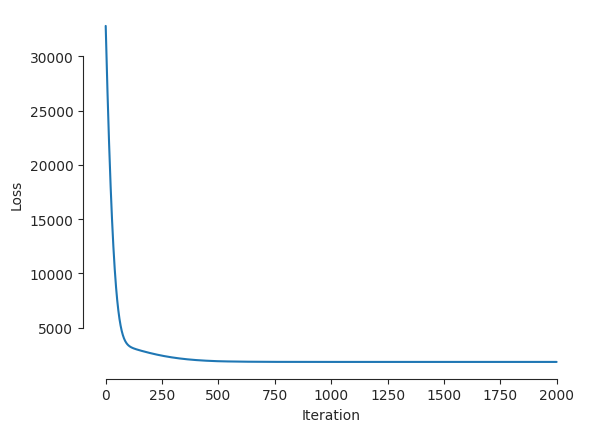

In [36]:
flow = Affine() # Initialize the affine flow model

def train(flow, train_size=2000):
    # Generate training data
    p_target = Laplace(5, 3)
    x = p_target.sample((train_size,)) 

    log_likelihood = optimize(x, flow, objective) # Run training

    # Plot log_likelihood over training iterations:
    with sns.axes_style('ticks'):
        plt.plot(log_likelihood)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
    sns.despine(trim=True)
    
train(flow)

### [2]: (1.5) Evaluation
Now that we have trained our first flow model, we want to inspect how well it works. For this purpose, we will now generate new samples from our target distribution $p_\mathrm{target}$ and compare them to the true samples we used for training.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


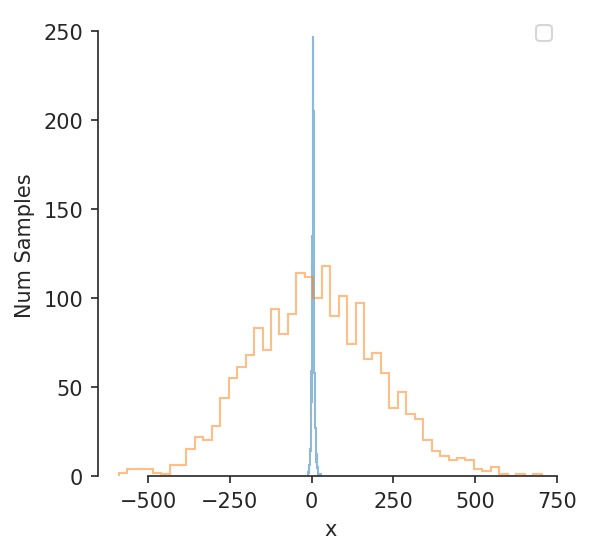

In [49]:
def evaluate(flow):
    p_source = Normal(0, 1)    
    p_target = Laplace(5, 3)
    x_true = p_target.sample((2000,1)) # samples to compare to  

    # Generate samples from source distribution
    z = p_source.sample((2000,1))

    # Use our trained model get samples from the target distribution
    x_flow, _ = flow.forward(z, inverse = True)
    
    # Plot histogram of training samples `x` and generated samples `x_flow` to compare the two.
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(4,4), dpi=150)
        ax.hist(x_true.detach().numpy().ravel(), bins=50, alpha=0.5,histtype='step');
        ax.hist(x_flow.detach().numpy().ravel(), bins=50, alpha=0.5,histtype='step');
        plt.xlabel("x")
        plt.ylabel("Num Samples")
        plt.legend()
    sns.despine(trim=True)
    
evaluate(flow)

Interpret the resulting plot.

## (2) Flow with composition of mutiple layers

### [3]: (2.1) A non-linear layer

After trying out our simple flow with a single affine layer above, we are now going to make our model a little more powerful by composing multiple simple functions.
For this, we first introduce a new simple function of the form:

 $$g(x)=\left\{\begin{array}{cc}{x} & {x>0} \\ {e^{x}-1} & {x \leqslant 0}\end{array}\right.$$
 

Now, similar to the affine layer we defined above, we now need to derive three components:

For the inverse:
$$
  g^{-1}(z) = \left\{\begin{array}{cl}{z} & {z>0} \\ {\log (z+1)} & {z \leqslant 0}\end{array}\right.
$$

For the derivative:
$$
\frac{d g}{d x}=\left\{\begin{array}{ll}{1} & {x>0} \\ {e^{x}} & {x \leqslant 0}\end{array}\right.
$$

For the derivative of the inverse:
$$
\frac{d g^{-1}}{d z}=\left\{\begin{array}{ll}{1} & {z>0} \\ {\frac{1}{z+1}} & {z \leqslant 0}\end{array}\right.
$$

Implementing this also follows the same pattern as for the affine layer. Fill in the forward function here:

In [ ]:
class NonLinear(nn.Module):
    def __init__(self):
        super().__init__()
   
    def forward(self, x, logdet, inverse=False):
        if not inverse:
            z = ...
            ld = ...
        else:
            z = ...
            ld =  ...
        logdet = logdet + ld
        return z, logdet

### [2]: (2.2) Stacking multiple layers

Now that we introduced a second type of layer, we can build more complex flow networks by stacking the individual layers on top of each other.
This means we want to use the following function:
$$
    g \circ f_{\theta_k} \circ ... \circ g \circ f_{\theta_1} = g(f_{\theta_k}(...g(f_{\theta_1}(x))...))
$$
Looking closely, we can see that this is simply a chained application of change of variables. 
Thus from the lecture, we can now the generalized objective function for a stacked network. 

$$
\mathcal{L} = \log p_\mathrm{source}(z) + \sum_{i=1}^{k} \log \left| \frac{df_i}{dz_{i-1}} \right|
$$

Now you should realise that the objective function we implemented earlier and the layers we implemented so far can already support the general case of composing multiple layers to a larger flow network. 
It does so by summing up the log-determinant term as we go through the layers in the forward pass.
What remains to do is the execution of the individual layers in the right order. 
Please implement this in the `forward` method of the following module that encapsulates all layers of our flow.

In [ ]:
class Flow(nn.Module):
    def __init__(self, layers=5):
        super().__init__()
        non_linear = NonLinear()
        self.layers = nn.ModuleList([])
        for _ in range(layers):
            self.layers.append(Affine())
            self.layers.append(non_linear)
            
    def forward(self, x, logdet=0, inverse=False):
        ... 
        return x, logdet

    

Now we have a more complex flow, let's test it out and evaluate our results:

In [ ]:
flow = Flow(layers=5)
train(flow)
evaluate(flow)

### [1]: (2.3) Final Evaluation
What do you observe? Can you think of another way to verify that your resulting flow network learned the target distribution?